In [1]:
#Le code suivant se divise en 3 parties.
# 1) Import et chargement des données
# 2) Préparation des données
# 3) création des modèles 
#
#
#
#

In [2]:
#import
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D,MaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from math import floor
from matplotlib import pyplot as plt
import pandas as pd
from keras.models import model_from_json, load_model
import json
from pathlib import Path

#utilisation du gpu
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1070, pci bus id: 0000:08:00.0, compute capability: 6.1



In [3]:
############################################## Chargement des données
#import données
commentaires_toxiques = pd.read_csv('data/commentaires_toxiques.csv')
#visualisation données
commentaires_toxiques.head()

#des fichiers .h5 et json sont presents dans le dossier models afin de ne pas avoir a réentrainer les models
#si vous voulez réentrainer les models, mettez CHARGEMENT_SAUVEGARDE = FALSE
CHARGEMENT_SAUVEGARDE = True
#Mettre sur true si vous souhaitez enregistrer les epochs du fit des differents models afin de les enregistrer dans un json
ENREGISTREMENT_HISTORIQUE = True

In [4]:
##############################################Préparation des données

#separation test et train

#variable entre 0 et 1 qui sépare le nombre de données en train et test
percentageTestTrain = 0.8

sepTestTrain = floor(len(commentaires_toxiques)*percentageTestTrain)
train=commentaires_toxiques[0:sepTestTrain]
test=commentaires_toxiques[sepTestTrain:len(commentaires_toxiques)]

#verification que train+test = taille total du dataset
print("Size dataset: ",len(commentaires_toxiques))
print("Size entrainement: ",train.shape[0])
print("Size test: ",test.shape[0])
print("Test + entrainement = Dataset: ",(train.shape[0] + test.shape[0])== commentaires_toxiques.shape[0])

#montre que le dataset ne possede pas de valeurs null (que nous devrions modifier dans ce cas)
print("\n \n \n Test si il y'a des valeurs nulles pour chaques colonnes")
train.isnull().any(),test.isnull().any()

Size dataset:  159571
Size entrainement:  127656
Size test:  31915
Test + entrainement = Dataset:  True

 
 
 Test si il y'a des valeurs nulles pour chaques colonnes


(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool)

In [5]:
# création des classes
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# recupere les valeurs des features (0 ou 1 pour chaque style de toxicité)
y_train = train[list_classes].values

#recupere chaque texte
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]
print("Nom des colonnes du dataset (", y_train.shape[1],")")
[print(x) for x in train.columns]
print("\n \nExemple de commentaire")

print(list_sentences_train[0])


Nom des colonnes du dataset ( 6 )
id
comment_text
toxic
severe_toxic
obscene
threat
insult
identity_hate

 
Exemple de commentaire
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [6]:
#tokenization -> "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
#Indexing -> 1:"I",2:"love",3:"cats",4:"and",5:"dogs"
#Index Representation -> represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. [1,2,3,4,2,5]

#nombre max de mot unique dans le dictionnaire
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)


# visualisation
# affichage les 10 premieres keys + values et de chercher 
# a partir d'une value ou d'une key

#maintenant les mots sont devenus des representations d'index
#affiche une ligne tokenizé

print("Exemple d'un commentaire après tokenization et indexing\n",list_tokenized_train[0],"\n \n")

word_index = tokenizer.word_index
itemsList = word_index.items()

#affiche les 10 premieres keys + values (items)
print("10 premiers mots et index")
for i in range(1,10):
    for item in itemsList:
        if item[1] == i:
            print(item[1], ":" , item[0])

#search from values
print("\nOn cherche le mot associé à la valeur 44")
for item in itemsList:
        if item[1] == 44:
            print(item[1], ":" , item[0])
print("\nOn cherche lindex associé à why")
#search from keys
if 'why' in word_index:
        print(word_index['why'])

Exemple d'un commentaire après tokenization et indexing
 [675, 76, 1, 127, 130, 177, 29, 662, 4585, 12613, 1090, 86, 333, 51, 2291, 11081, 50, 6975, 15, 60, 2778, 146, 7, 2952, 34, 116, 1205, 14350, 2766, 4, 45, 59, 245, 1, 377, 32, 1, 37, 27, 144, 74, 3619, 89, 3010, 4417, 2180, 1003] 
 

10 premiers mots et index
1 : the
2 : to
3 : of
4 : and
5 : a
6 : you
7 : i
8 : is
9 : that

On cherche le mot associé à la valeur 44
44 : will

On cherche lindex associé à why
76


In [7]:
#ce code a été commenté car l'output est très long
#voir les occurences des mots
#tokenizer.word_counts
#voir les indexs des mots
#tokenizer.word_index

[47, 17, 42, 114, 13, 11, 8, 19, 84, 11]


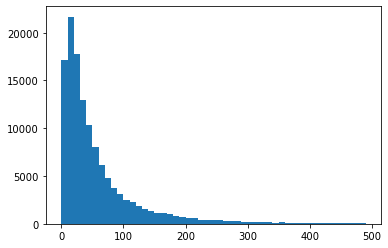

36.7% des textes ont une taille supérieur à 50


In [8]:
maxlen = 200
#remplis le texte de rien si jamais un texte est trop court
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

#permet de voir la taille moyenne des commentaires pour modifier la variable maxlen
def affichage_taille_moyenne(list_tokenized_train):
    totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
    print(totalNumWords[0:10])
    plt.hist(totalNumWords,bins = np.arange(0,500,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
    plt.show()
    return totalNumWords
    
totalNumWords = affichage_taille_moyenne(list_tokenized_train)




#juste un test pour voir le nombre de texte dont la taille est > a NB_BETTER
#si ya un moyen plus simple jsuis chaud
def nb_better_than(totalNumWords, NB_BETTER):
    #NB_BETTER = 40
    numberbetterthanNB_BETTER = [1 if total > NB_BETTER else 0 for total in totalNumWords]
    #print(len(numberbetterthanNB_BETTER))
    #print(numberbetterthanNB_BETTER.count(1))
    print(f"{round(numberbetterthanNB_BETTER.count(1)/len(totalNumWords)*100, 1)}% des textes ont une taille supérieur à {NB_BETTER}")
    
nb_better_than(totalNumWords, 50)

In [9]:
#fonction qui sauvegarde un model en .h5 et .json dans le fichier models
def sauvegarde(model, nom_model):
    model_json = model.to_json()
    with open("models/"+str(nom_model)+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("models/"+str(nom_model)+".h5")
    


#fonction qui charge un model a partir du .json et du .h5
#il faut lui donner un string correspondant au nom du model sauvegarde
#retourne le model
def chargement_model(nom_model):
    # load json and create model
    json_file = open("models/"+str(nom_model)+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights 
    loaded_model.load_weights("models/"+str(nom_model)+".h5")
    return loaded_model


#fonction qui va entrainer en model en entree avec le nomre d'epochs ecrit en entree
#retourne le model et l'historique des epochs
def entrainement_model(model,epochs):
    batch_size = 32
    #epochs = 5
    history_model = model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    return model, history_model

#fonction qui sauvegarde l'historique des epochs quand un model s'entraine dans un fichier .json afin de réutiliser ces données
#sans avoir à réentrainer le model
def sauvegarde_historique(history_model, nom_model):
        hist_df = pd.DataFrame(history_model.history) 
        hist_json_file = 'models/history_'+nom_model+'.json' 
        with open(hist_json_file, mode='w') as f:
            hist_df.to_json(f)

In [10]:
################################# Création de différents modéles

In [11]:
#model super simple pour commencer:
#vu le temps élevé necessaire pour faire le model il est possible de load directement les models stockes dans models/

def create_model_simple():
    inp_simple = Input(shape=(maxlen, ))
    embed_size = 128
    x_simple = Embedding(max_features, embed_size)(inp_simple)
    x_simple = Flatten()(x_simple)
    x_simple = Dense(units=500, activation='relu')(x_simple)
    x_simple = Dense(units=6, activation='sigmoid')(x_simple)

    model_simple = Model(inputs=inp_simple, outputs=x_simple)
    model_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model_simple.summary())
    return model_simple

#crée le model simple
#si CHARGEMENT_SAUVEGARDE == False, entraine le model de nouveau sinon va chercher le fichier poids et json correspondant dans models/
def creation_entrainement_simple():
    if CHARGEMENT_SAUVEGARDE == False:
        #creation du model
        model_simple = create_model_simple()

        #fit du model et enregistrement de l'historique
        model_simple, history_model_simple = entrainement_model(model_simple,2)
        #sauvegarde du model en json et .h5
        sauvegarde(model_simple, "model_simple")
        
        #enregistrement des epochs dans un json pour pouvoir les reutiliser sans avoir a reentrainer le model
        if ENREGISTREMENT_HISTORIQUE == True:
            sauvegarde_historique(history_model_simple, "model_simple")

    else:
        model_simple = chargement_model("model_simple")
        print("Le model a bien été chargé")
        print(model_simple)
    return model_simple

model_simple = creation_entrainement_simple()

Le model a bien été chargé


In [12]:
#Convolutional Neutral Network
def create_model_cnn():
    inp_cnn = Input(shape=(maxlen, ))
    embed_size = 128
    x_cnn = Embedding(max_features, embed_size)(inp_cnn)
    x_cnn = Conv1D(60, 5, activation='relu')(x_cnn)
    x_cnn = MaxPooling1D(5)(x_cnn)
    x_cnn = Flatten()(x_cnn)
    x_cnn = Dense(units=50, activation='relu')(x_cnn)
    x_cnn = Dense(units=6, activation='sigmoid')(x_cnn)

    model_cnn = Model(inputs=inp_cnn, outputs=x_cnn)
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model_cnn.summary())
    return model_cnn

def creation_entrainement_cnn():
    if CHARGEMENT_SAUVEGARDE == False:
        #creation du model
        model_cnn = create_model_cnn()

        #fit du model et enregistrement de l'historique
        model_cnn, history_model_cnn = entrainement_model(model_cnn,2)

        #sauvegarde du model en json et .h5
        sauvegarde(model_cnn, "model_cnn")
        
        #enregistrement des epochs dans un json pour pouvoir les reutiliser sans avoir a reentrainer le model
        if ENREGISTREMENT_HISTORIQUE == True:
            sauvegarde_historique(history_model_cnn, "model_cnn")
    else:
        model_cnn = chargement_model("model_cnn")
        print("Le model a bien été chargé")
        print(model_cnn)
        return model_cnn
    
model_cnn = creation_entrainement_cnn()

Le model a bien été chargé


In [13]:
#creation du modele
#ici on utilise LSTM
def create_model_lstm():
    inp_lstm = Input(shape=(maxlen, )) #maxlen=200 comme defini plus tot
    embed_size = 128
    x_lstm = Embedding(max_features, embed_size)(inp_lstm)
    x_lstm = LSTM(60, return_sequences=True,name='lstm_layer')(x_lstm)
    x_lstm = GlobalMaxPool1D()(x_lstm)
    x_lstm = Dropout(0.1)(x_lstm)
    x_lstm = Dense(50, activation="relu")(x_lstm)
    x_lstm = Dropout(0.1)(x_lstm)
    x_lstm = Dense(6, activation="sigmoid")(x_lstm)
    #compilation
    model_lstm = Model(inputs=inp_lstm, outputs=x_lstm)
    model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_lstm.summary()
    return model_lstm

def creation_entrainement_lstm():
    if CHARGEMENT_SAUVEGARDE == False:
        #creation du model
        model_lstm = create_model_lstm()

        #fit du model et enregistrement de l'historique
        model_lstm, history_model_lstm = entrainement_model(model_lstm,2)

        #sauvegarde du model en json et .h5
        sauvegarde(model_lstm, "model_lstm")
        
        #enregistrement des epochs dans un json pour pouvoir les reutiliser sans avoir a reentrainer le model
        if ENREGISTREMENT_HISTORIQUE == True:
            sauvegarde_historique(history_model_lstm, "model_lstm")
    else:
        model_lstm = chargement_model("model_lstm")
        print("Le model a bien été chargé")
        print(model_lstm)
    return model_lstm

model_lstm = creation_entrainement_lstm()

Le model a bien été chargé


In [14]:
from numpy import zeros, asarray

def chargement_glove(tokenizer):
    vocab_size = len(tokenizer.word_index) + 1

    # load the whole embedding into memory
    # a telecharger sur https://nlp.stanford.edu/projects/glove/ et unzip "glove.6B.100d.txt" dans le fichier embeddings qui est a creer si non existantt
    embeddings_index = dict()
    f = open('embeddings/glove.6B.100d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))


    # create a weight matrix for words in training docs
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    print("Done")
    return embedding_matrix


In [15]:
def create_model_glove():
    embedding_matrix = chargement_glove(tokenizer)
    #model avec embedding glove/word2vec
    inp_glove = Input(shape=(maxlen, )) #maxlen=200 comme defini plus tot 
    embed_size = 100
    x_glove = Embedding(max_features, embed_size, weights=[embedding_matrix[:max_features]], trainable=False)(inp_glove)
    # we do not want to update the learned word weights in this model
    x_glove = LSTM(60, return_sequences=True,name='lstm_layer')(x_glove)
    x_glove = GlobalMaxPool1D()(x_glove)
    x_glove = Dropout(0.1)(x_glove)
    x_glove = Dense(50, activation="relu")(x_glove)
    x_glove = Dropout(0.1)(x_glove)
    x_glove = Dense(6, activation="sigmoid")(x_glove)

    model_glove = Model(inputs=inp_glove, outputs=x_glove)
    model_glove.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    model_glove.summary()
    return model_glove

def creation_entrainement_glove():
    if CHARGEMENT_SAUVEGARDE == False:
        #creation du model
        model_glove = create_model_glove()

        #fit du model et enregistrement de l'historique
        model_glove, history_model_glove = entrainement_model(model_glove,2)

        #sauvegarde du model en json et .h5
        sauvegarde(model_glove, "model_glove")
        
        #enregistrement des epochs dans un json pour pouvoir les reutiliser sans avoir a reentrainer le model
        if ENREGISTREMENT_HISTORIQUE == True:
            sauvegarde_historique(history_model_glove, "model_glove")
    else:
        model_glove = chargement_model("model_glove")
        print("Le model a bien été chargé")
        print(model_glove)
    return model_glove

model_glove = creation_entrainement_glove()

Le model a bien été chargé


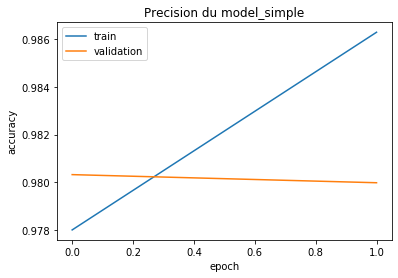

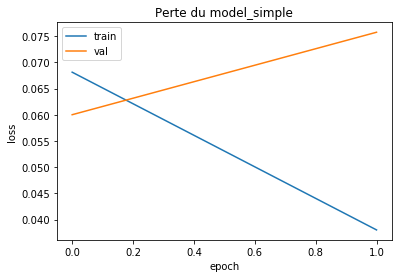

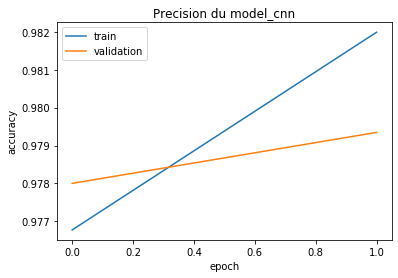

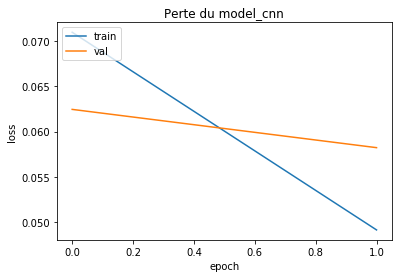

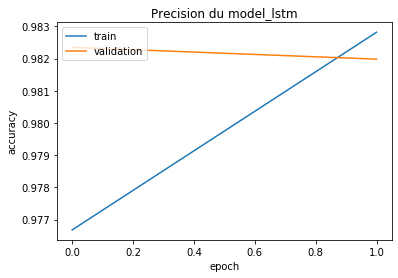

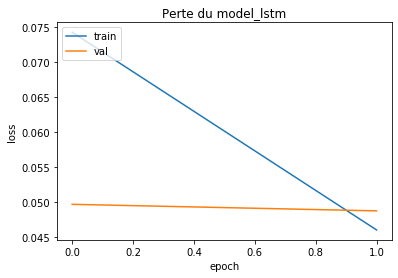

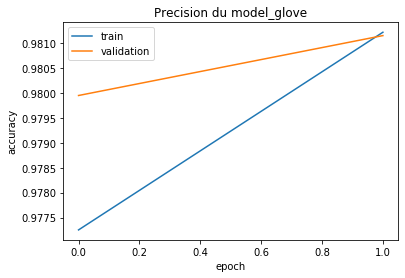

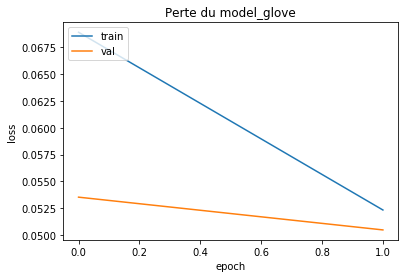

In [16]:
#visualisation
#plot de la precision du model en entree
#plot de la loss du model en entree
#peut etre a montrer pour expliquer pourquoi il n'est pas utile de faire plus de 2 epochs

#acc is the accuracy of a batch of training data and val_acc is the accuracy of a batch of testing data.
#val_acc is the accuracy computed on the validation set (data that have never been 'seen' by the model). 

#val_loss is the value of cost function for your cross-validation data and loss is the value of cost function 
#for your training data.


def visualisation2(nom_model):
    my_file = Path("models/history_"+str(nom_model)+".json")
    if my_file.is_file():
        with open("models/history_"+str(nom_model)+".json", 'r') as json_file:
            history_model = json.load(json_file)
#             print(history_model_simple2['accuracy'])    
#             print(list(history_model_simple2['accuracy'].values()))
#             print(history_model_simple.history['accuracy'])

        plt.plot(list(history_model['accuracy'].values()))
        plt.plot(list(history_model['val_accuracy'].values()))
        plt.title('Precision du '+nom_model)
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

        plt.plot(list(history_model['loss'].values()))
        plt.plot(list(history_model['val_loss'].values()))
        plt.title('Perte du '+nom_model)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    else:
        print("pas de fichier historique existant pour ce nom de model")

def visualisation_epoch_models(nom_list_models):
    for nom_model in nom_list_models:
        visualisation2(nom_model)

visualisation_epoch_models(["model_simple", "model_cnn", "model_lstm", "model_glove"])



In [17]:
#test sur une phrase
#fonction qui test sur tout les modeles une phrase ecrite en entree        
def prediction_phrase_all_models(phrase):
    tokens = tokenizer.texts_to_sequences([phrase])
    X_tokens = pad_sequences(tokens, maxlen=maxlen)
    list_models =[model_simple, model_cnn, model_lstm, model_glove]
    #list_models =[model_simple]
    list_models_nom=["model simple", "model cnn", "model lstm", "model glove"]
    #list_models_nom=["model simple"]

    for model in range(len(list_models)):
        print("Voici le résultat pour le texte suivant: ",phrase, "avec le model suivant:", list_models_nom[model])
        res_pred = list_models[model].predict(np.array(X_tokens))
        for i in range(len(list_classes)):
            print(list_classes[i],":",round(res_pred[0][i],3))

prediction_phrase_all_models("really nigga?")





Voici le résultat pour le texte suivant:  really nigga? avec le model suivant: model simple
toxic : 0.877
severe_toxic : 0.018
obscene : 0.101
threat : 0.006
insult : 0.463
identity_hate : 0.579
Voici le résultat pour le texte suivant:  really nigga? avec le model suivant: model cnn
toxic : 0.223
severe_toxic : 0.005
obscene : 0.055
threat : 0.01
insult : 0.062
identity_hate : 0.014
Voici le résultat pour le texte suivant:  really nigga? avec le model suivant: model lstm
toxic : 0.758
severe_toxic : 0.015
obscene : 0.279
threat : 0.018
insult : 0.297
identity_hate : 0.054
Voici le résultat pour le texte suivant:  really nigga? avec le model suivant: model glove
toxic : 0.9
severe_toxic : 0.063
obscene : 0.769
threat : 0.026
insult : 0.44
identity_hate : 0.033


In [18]:
def prediction_phrase_un_seul_model(phrase, model, nom_model):
    tokens = tokenizer.texts_to_sequences([phrase])
    X_tokens = pad_sequences(tokens, maxlen=maxlen)

    print("Voici le résultat pour le texte suivant: ",phrase, "avec le model suivant:", nom_model)
    res_pred = model.predict(np.array(X_tokens))
    dict_proba_toxic={}
    #proba_toxic=[]
    for i in range(len(list_classes)):
        print(list_classes[i],":",round(res_pred[0][i],3))
        #proba_toxic.append(round(res_pred[0][i],3))
        dict_proba_toxic[list_classes[i]] = round(res_pred[0][i],3)
    return dict_proba_toxic   

dict_proba_toxic = prediction_phrase_un_seul_model("really niggaa", model_cnn, "model_cnn")


Voici le résultat pour le texte suivant:  really niggaa avec le model suivant: model_cnn
toxic : 0.267
severe_toxic : 0.008
obscene : 0.068
threat : 0.014
insult : 0.079
identity_hate : 0.019


In [23]:
def prediction_phrase_model_visualisation():
    phrase = value.get()
    tokens = tokenizer.texts_to_sequences([phrase])
    X_tokens = pad_sequences(tokens, maxlen=maxlen)
    if value2.get() == "model_simple":
        model = model_simple
    elif value2.get() == "model_cnn":
        model = model_cnn
    elif value2.get() == "model_lstm":
        model = model_lstm
    elif value2.get() == "model_glove":
        model = model_glove
    else:
        pass
    print("Voici le résultat pour le texte suivant: ",phrase, "avec le model suivant:", value2.get())
    res_pred = model.predict(np.array(X_tokens))
    dict_proba_toxic={}
    #proba_toxic=[]
    for i in range(len(list_classes)):
        print(list_classes[i],":",round(res_pred[0][i],3))
        #proba_toxic.append(round(res_pred[0][i],3))
        dict_proba_toxic[list_classes[i]] = round(res_pred[0][i],3)
        
    
    frame2 = Frame(window, background='#D2CAEC', relief=SUNKEN, bd=1)
    frame2.grid(row=5,pady=(20,10))
    
    toxic = dict_proba_toxic['toxic']
    var_toxic = StringVar()
    var_toxic.set(toxic)
    severe_toxic = dict_proba_toxic['severe_toxic']
    var_severe_toxic = StringVar()
    var_severe_toxic.set(severe_toxic)
    obscene = dict_proba_toxic['obscene']
    var_obscene = StringVar()
    var_obscene.set(obscene)
    threat = dict_proba_toxic['threat']
    var_threat = StringVar()
    var_threat.set(threat)
    insult = dict_proba_toxic['insult']
    var_insult = StringVar()
    var_insult.set(insult)
    identity_hate = dict_proba_toxic['identity_hate']
    var_identity_hate = StringVar()
    var_identity_hate.set(identity_hate)
    
    list_classes1 = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    for class1 in range(1,len(list_classes1)+1):
        label_class = Label(frame2, text=list_classes1[class1-1], background='#D2CAEC', relief=SUNKEN, bd=1, width=10)
        label_class.grid(row=1,column=class1)
    label_toxic = Label(frame2, textvariable=var_toxic, background='#D2CAEC', relief=SUNKEN, bd=1, width=10)
    label_toxic.grid(row=2,column=1)
    label_severe_toxic = Label(frame2, textvariable=var_severe_toxic, background='#D2CAEC', relief=SUNKEN, bd=1, width=10)
    label_severe_toxic.grid(row=2,column=2)
    label_obscene = Label(frame2, textvariable=var_obscene, background='#D2CAEC', relief=SUNKEN, bd=1, width=10)
    label_obscene.grid(row=2,column=3)
    label_threat = Label(frame2, textvariable=var_threat, background='#D2CAEC', relief=SUNKEN, bd=1, width=10)
    label_threat.grid(row=2,column=4)
    label_insult = Label(frame2, textvariable=var_insult, background='#D2CAEC', relief=SUNKEN, bd=1, width=10)
    label_insult.grid(row=2,column=5)
    label_identity_hate = Label(frame2, textvariable=var_identity_hate, background='#D2CAEC', relief=SUNKEN, bd=1, width=10)
    label_identity_hate.grid(row=2,column=6)
  

In [24]:
#a completer a refaire vu la modif de la gestion de lhistorique
# list_history_models =[history_model_simple, history_model_cnn, history_model_lstm, history_model_glove]
# for history_model in range(len(list_history_models)):
#     print(list_history_models[history_model].history['val_accuracy'])

In [ ]:
from tkinter import *
import string

window = Tk()
window.title("Toxicity Dectector")
window.geometry("480x360")
window.minsize(480, 360)
window.maxsize(480, 360)
#window.iconbitmap("714043.svg.ico")
window.config(background='#D2CAEC')

label_nb_place = Label(window, text="Welcome to the toxicity detector", background='#D2CAEC',font=('Arial', 14))
label_nb_place.grid(row=0,pady=(10,0))
label_phrase = Label(window, text="Please write below the sentence for which you want to determine the type of toxicity", background='#D2CAEC',font=('Arial', 8))
label_phrase.grid(row=1,pady=(30,0))
value = StringVar() 
value.set("wanna fight with me faggot?")
entree = Entry(window, textvariable=value, width=(50))
entree.grid(row=2,pady=(5,0))


bouton=Button(window, text="Start", command= lambda: prediction_phrase_model_visualisation())
bouton.grid(row=4,pady=(10,10))

frame1 = Frame(window, background='#D2CAEC', relief=SUNKEN, bd=1)
frame1.grid(row=3,pady=(20,10))

value2 = StringVar() 
bouton1 = Radiobutton(frame1, text="model_simple", variable=value2, value="model_simple")
bouton2 = Radiobutton(frame1, text="model_cnn", variable=value2, value="model_cnn")
bouton3 = Radiobutton(frame1, text="model_lstm", variable=value2, value="model_lstm")
bouton4 = Radiobutton(frame1, text="model_glove", variable=value2, value="model_glove")

bouton1.grid(row=1,column=1)
bouton2.grid(row=1,column=2)
bouton3.grid(row=1,column=3)
bouton4.grid(row=1,column=4)
bouton1.select()

window.columnconfigure(0, weight=1)

window.mainloop()

Voici le résultat pour le texte suivant:  wanna fight with me faggot? avec le model suivant: model_cnn
toxic : 0.14
severe_toxic : 0.002
obscene : 0.028
threat : 0.004
insult : 0.024
identity_hate : 0.005
Voici le résultat pour le texte suivant:  wanna fight with me faggot? avec le model suivant: model_lstm
toxic : 0.988
severe_toxic : 0.123
obscene : 0.939
threat : 0.016
insult : 0.679
identity_hate : 0.082
Voici le résultat pour le texte suivant:  wanna fight with me faggot? avec le model suivant: model_simple
toxic : 0.968
severe_toxic : 0.019
obscene : 0.567
threat : 0.003
insult : 0.529
identity_hate : 0.076
